In [60]:
#Imports

# Library imports
import torch
import torch.nn as nn

import torch.nn.functional as F
import torchsummary
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision . datasets import MNIST
import torchvision.transforms as transforms # Image Transforms
import torchvision . transforms as tt
from torch.utils.data.sampler import SubsetRandomSampler # Sampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn.manifold import TSNE
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte uint8 para float [0, 1]
])
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Lets start to obtain training indices
num_train = len(train_dataset.data)
print("Number of images in original training set: " + str(num_train)) # 60 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 12 000
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] # 48 000 / 12 000
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

# Lets also see how many images are on testing set
print("Number of images in the testing set: " + str(len(test_dataset.data))) # 10 000

training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=training_sampler)
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 164kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.06MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.38MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Number of images in original training set: 60000
Split Number: 12000
Number of training images: 48000
Number of validation images: 12000
Number of images in the testing set: 10000


### EDA



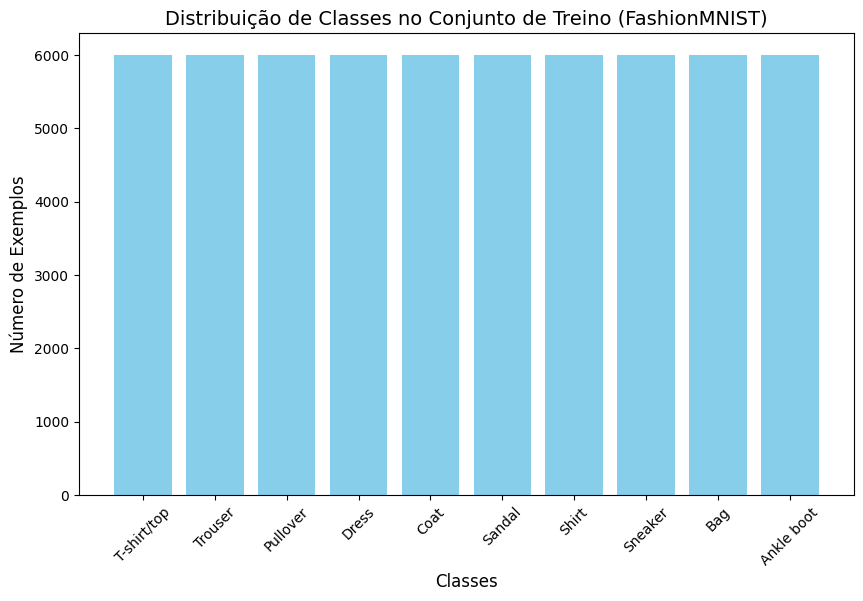

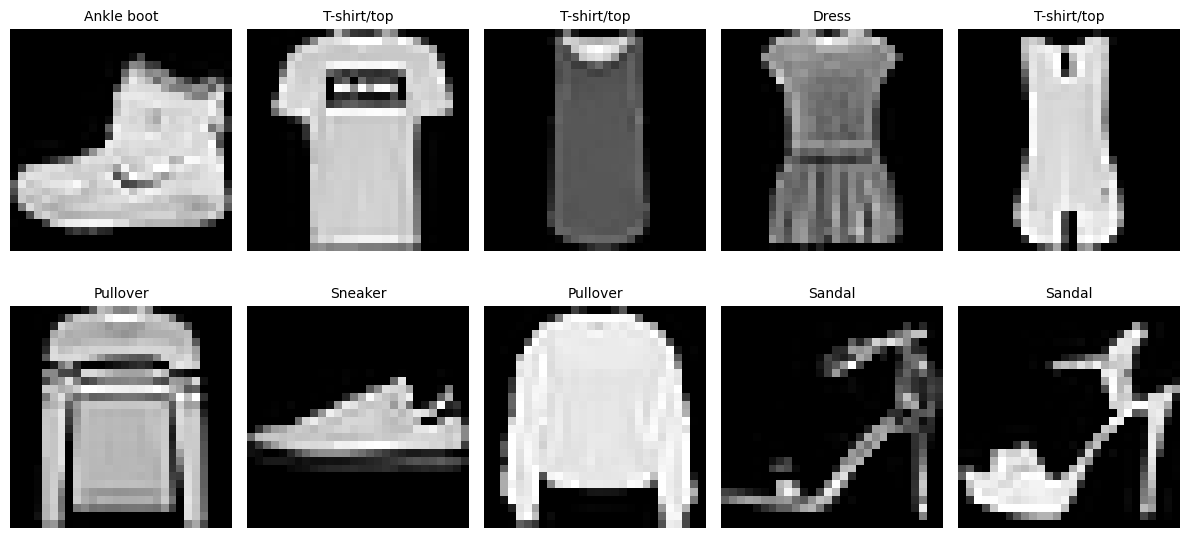

In [ ]:
# Dicionário para mapear índices das classes para nomes.
class_names = train_dataset.classes

# Distribuição de classes no conjunto de treino
train_classes = [label for _, label in train_dataset]
class_counts = {class_names[i]: train_classes.count(i) for i in range(len(class_names))}

# Visualizar a distribuição de classes
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribuição de Classes no Conjunto de Treino (FashionMNIST)", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Número de Exemplos", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Visualizar exemplos de imagens do dataset
def plot_examples(dataset, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        image, label = dataset[i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(class_names[label], fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_examples(train_dataset)



## AutoEncoder

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=3),  # 14x14 -> 5x5
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 5x5 -> 5x5
            nn.ReLU(),
            nn.Conv2d(32, 128, kernel_size=3, padding=1, stride=2),  # 5x5 -> 3x3
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=3, output_padding=1, padding=1, stride=2),  # 3x3 -> 5x5
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # 5x5 -> 5x5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, output_padding=1, padding=1, stride=3),  # 5x5 -> 14x14
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.Upsample(size=28),  # Restore size to 28x28
            nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1, stride=1),  # 14x14 -> 28x28
            nn.Sigmoid(),  # Normalize to [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded





In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device="cpu"):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = batch[0].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)  # Reconstruction loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = batch[0].to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()

                # Log qualitative reconstructions periodically
                #if batch[0].shape[0] >= 5 and epoch % 5 == 0:
                #    visualize_reconstructions(images, outputs)

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Update scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_autoencoder.pth")
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

    return train_losses, val_losses

In [17]:
def visualize_reconstructions(inputs, outputs, num_samples=10):

    inputs = inputs.cpu().numpy()
    outputs = outputs.detach().cpu().numpy()  # Detach before converting to NumPy

    # Compute reconstruction error (Mean Squared Error for each sample)
    errors = np.mean((inputs - outputs) ** 2, axis=(1, 2, 3))  # Average over all pixels

    print(f"Reconstruction Errors: {errors}")

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 5))
    for i in range(num_samples):
        # Show original image
        axes[0, i].imshow(inputs[i, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Show reconstructed image with error
        axes[1, i].imshow(outputs[i, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Reconstruction\nError: {errors[i]:.4f}")

    plt.tight_layout()
    plt.show()


def plot_latent_space(model, data_loader, device="cpu", num_points=1000):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            encoded = model(images)  # Extract latent vectors
            latent_vectors.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(lbls.numpy())
            if len(labels) >= num_points:
                break

    latent_vectors = np.concatenate(latent_vectors, axis=0)[:num_points]
    labels = np.array(labels[:num_points])

    # Reduce dimensionality to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_latents = tsne.fit_transform(latent_vectors)

    # Plot the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=labels, cmap="tab10", s=15)
    plt.colorbar(scatter, label="Class Labels")
    plt.title("Latent Space Visualization")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()


def plot_loss_curves(train_losses, val_losses, title="Loss Curves"):
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch 1/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 151.79it/s]


Best model saved with validation loss: 0.0145
Epoch 1/25:
Train Loss: 0.0272, Val Loss: 0.0145, Time: 15.41s


Epoch 2/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 180.40it/s]


Best model saved with validation loss: 0.0120
Epoch 2/25:
Train Loss: 0.0131, Val Loss: 0.0120, Time: 14.58s


Epoch 3/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 207.02it/s]


Best model saved with validation loss: 0.0106
Epoch 3/25:
Train Loss: 0.0112, Val Loss: 0.0106, Time: 14.92s


Epoch 4/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 209.92it/s]


Best model saved with validation loss: 0.0098
Epoch 4/25:
Train Loss: 0.0101, Val Loss: 0.0098, Time: 14.51s


Epoch 5/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.95it/s]


Best model saved with validation loss: 0.0093
Epoch 5/25:
Train Loss: 0.0094, Val Loss: 0.0093, Time: 14.82s


Epoch 6/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 140.46it/s]


Best model saved with validation loss: 0.0087
Epoch 6/25:
Train Loss: 0.0089, Val Loss: 0.0087, Time: 15.57s


Epoch 7/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 191.69it/s]


Best model saved with validation loss: 0.0084
Epoch 7/25:
Train Loss: 0.0085, Val Loss: 0.0084, Time: 15.04s


Epoch 8/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 199.85it/s]


Best model saved with validation loss: 0.0080
Epoch 8/25:
Train Loss: 0.0081, Val Loss: 0.0080, Time: 14.89s


Epoch 9/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 197.15it/s]


Best model saved with validation loss: 0.0077
Epoch 9/25:
Train Loss: 0.0079, Val Loss: 0.0077, Time: 14.71s


Epoch 10/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 192.84it/s]


Best model saved with validation loss: 0.0076
Epoch 10/25:
Train Loss: 0.0076, Val Loss: 0.0076, Time: 14.94s


Epoch 11/25 - Validation: 100%|██████████| 375/375 [00:03<00:00, 124.10it/s]


Best model saved with validation loss: 0.0075
Epoch 11/25:
Train Loss: 0.0074, Val Loss: 0.0075, Time: 15.68s


Epoch 12/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 147.50it/s]


Best model saved with validation loss: 0.0072
Epoch 12/25:
Train Loss: 0.0072, Val Loss: 0.0072, Time: 15.88s


Epoch 13/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 176.56it/s]


Best model saved with validation loss: 0.0070
Epoch 13/25:
Train Loss: 0.0070, Val Loss: 0.0070, Time: 14.50s


Epoch 14/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 206.32it/s]


Best model saved with validation loss: 0.0068
Epoch 14/25:
Train Loss: 0.0069, Val Loss: 0.0068, Time: 14.83s


Epoch 15/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 199.56it/s]


Best model saved with validation loss: 0.0067
Epoch 15/25:
Train Loss: 0.0067, Val Loss: 0.0067, Time: 14.74s


Epoch 16/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 212.61it/s]


Epoch 16/25:
Train Loss: 0.0066, Val Loss: 0.0068, Time: 14.45s


Epoch 17/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 207.92it/s]


Best model saved with validation loss: 0.0064
Epoch 17/25:
Train Loss: 0.0065, Val Loss: 0.0064, Time: 14.70s


Epoch 18/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 207.75it/s]


Best model saved with validation loss: 0.0064
Epoch 18/25:
Train Loss: 0.0064, Val Loss: 0.0064, Time: 14.67s


Epoch 19/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 207.62it/s]


Best model saved with validation loss: 0.0063
Epoch 19/25:
Train Loss: 0.0063, Val Loss: 0.0063, Time: 14.93s


Epoch 20/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 204.51it/s]


Best model saved with validation loss: 0.0062
Epoch 20/25:
Train Loss: 0.0061, Val Loss: 0.0062, Time: 14.56s


Epoch 21/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 204.48it/s]


Best model saved with validation loss: 0.0061
Epoch 21/25:
Train Loss: 0.0060, Val Loss: 0.0061, Time: 14.80s


Epoch 22/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 198.40it/s]


Best model saved with validation loss: 0.0060
Epoch 22/25:
Train Loss: 0.0060, Val Loss: 0.0060, Time: 14.68s


Epoch 23/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 173.15it/s]


Epoch 23/25:
Train Loss: 0.0059, Val Loss: 0.0060, Time: 14.85s


Epoch 24/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 158.33it/s]


Best model saved with validation loss: 0.0058
Epoch 24/25:
Train Loss: 0.0058, Val Loss: 0.0058, Time: 14.97s


Epoch 25/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 134.58it/s]


Epoch 25/25:
Train Loss: 0.0057, Val Loss: 0.0058, Time: 15.29s


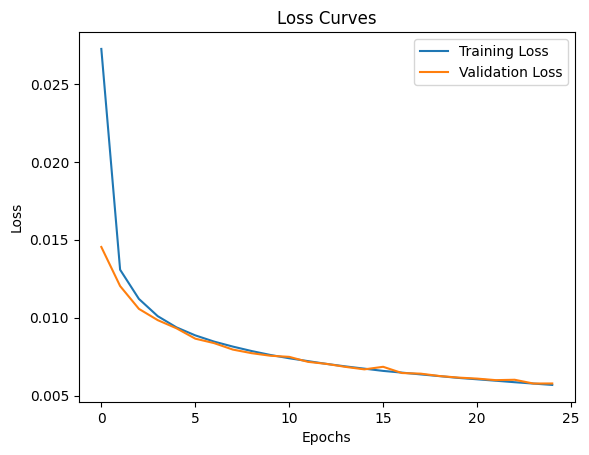

In [10]:
ae = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

# Train the autoencoder
train_losses, val_losses = train(
    model=ae,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device=device,
)

plot_loss_curves(train_losses, val_losses)

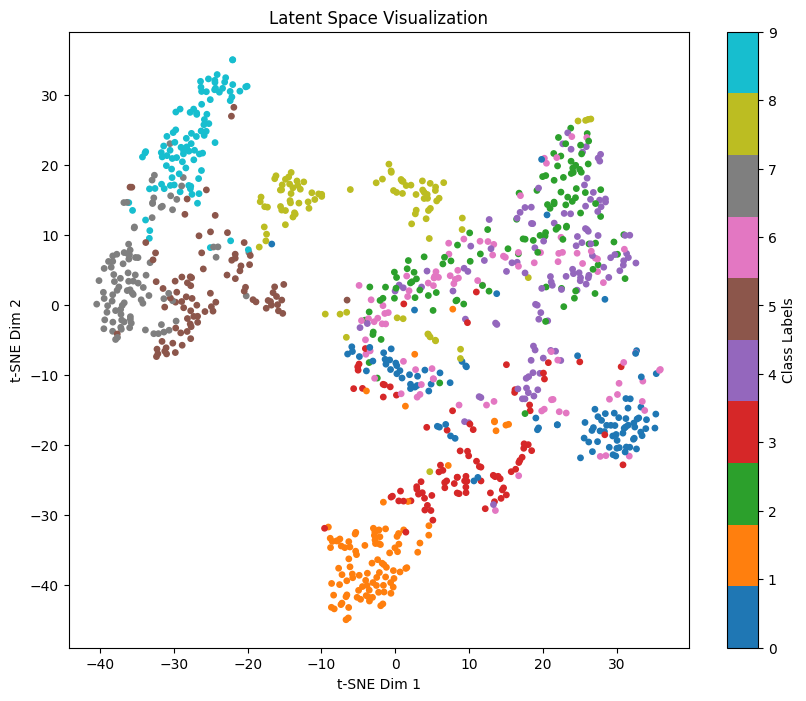

In [13]:
plot_latent_space(model=ae, data_loader=test_loader, device=device, num_points=1000)

In [20]:
def evaluate_autoencoder(autoencoder, test_loader, device):

    autoencoder.eval()
    reconstruction_errors = []
    latent_space = []
    labels = []

    criterion = torch.nn.MSELoss()  # Reconstruction loss

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)

            # Forward pass
            decoded = autoencoder(images)

            # Compute reconstruction error
            loss = criterion(decoded, images)
            reconstruction_errors.append(loss.item())

            # Extract latent representation
            encoded = autoencoder.encoder(images)
            latent_space.append(encoded.view(encoded.size(0), -1).cpu())  # Flatten latent space
            labels.append(targets)

    # Concatenate latent space and labels for visualization
    latent_space = torch.cat(latent_space, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Visualize the latent space using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_space)

    plt.figure(figsize=(8, 8))
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar()
    plt.title("t-SNE Visualization of Latent Space")
    plt.show()

    # Return the mean reconstruction error
    mean_reconstruction_error = np.mean(reconstruction_errors)
    print(f"Média do Erro de Reconstrução: {mean_reconstruction_error:.6f}")
    return mean_reconstruction_error

Reconstruction Errors: [0.0019844  0.01460666 0.00136791 0.00237586 0.00588851 0.00264199
 0.00996355 0.01902628 0.00327945 0.00545672]


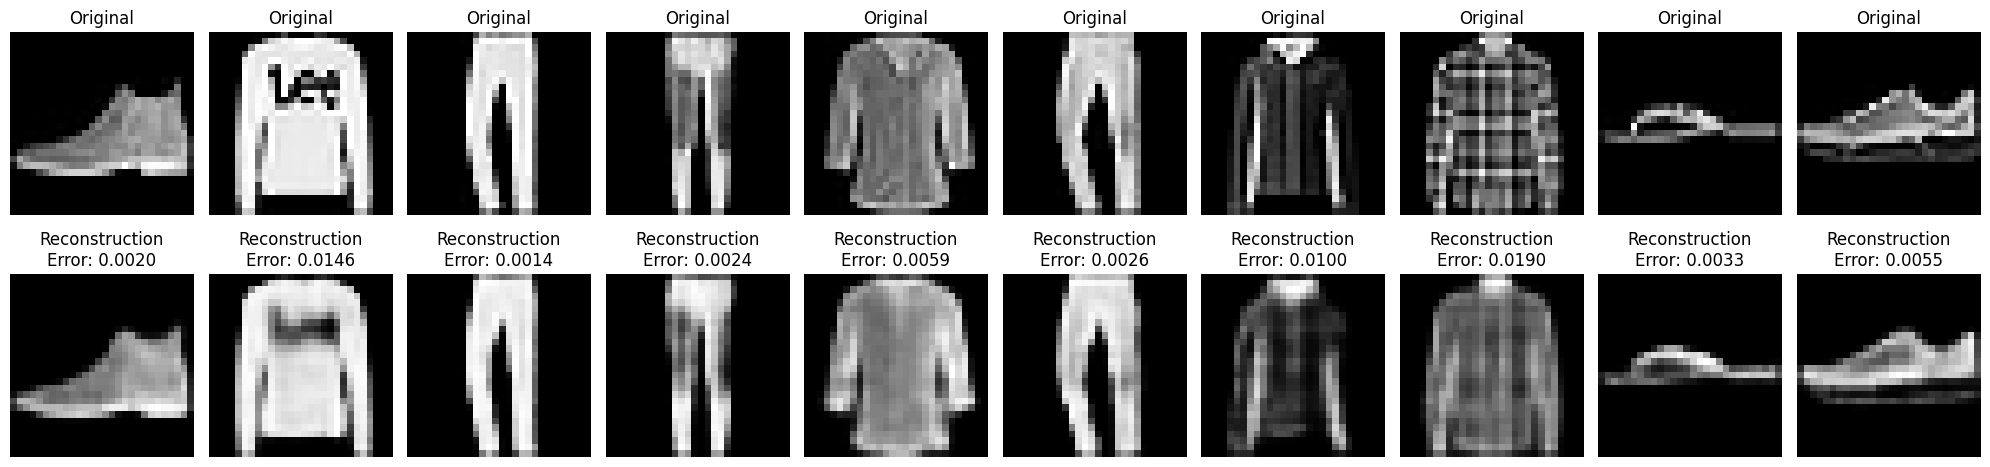

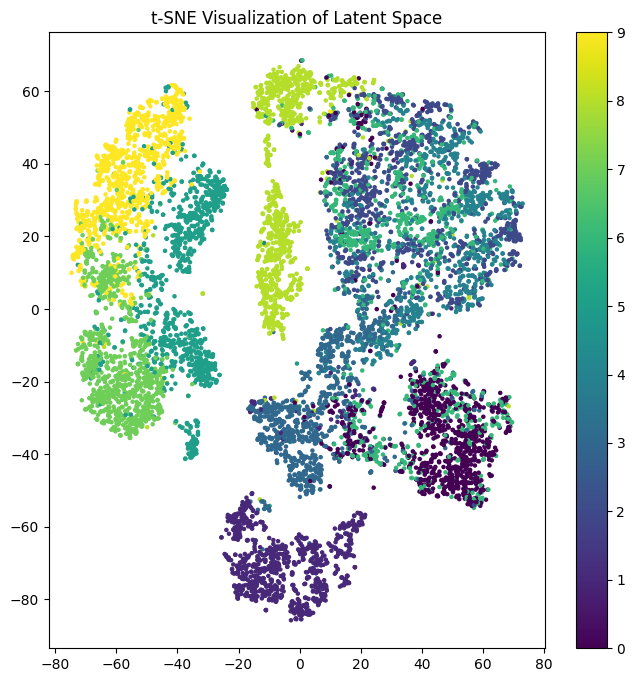

Média do Erro de Reconstrução: 0.005787


0.00578717511004438

In [21]:
inputs, _ = next(iter(test_loader))  # Get a batch of test data
inputs = inputs[:10]  # Select 10 samples
outputs = ae(inputs.to(device))  # Forward pass through the model

visualize_reconstructions(inputs, outputs)
evaluate_autoencoder(ae, test_loader, device)

## VAE


In [22]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),  # 7x7 -> 4x4
            nn.ReLU(),
            nn.Flatten()
        )

        # Bottleneck layers
        self.fc_mu = nn.Linear(32 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(32 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 32 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 4, 4)),  # Reshape latent vector into feature maps
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  # 4x4 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Normalize pixel values to [0, 1]
        )

    def reparameterization(self, mu, logvar):
        """
        Apply the reparameterization trick: z = μ + σ * ε
        """
        std = torch.exp(0.5 * logvar)  # Compute σ from log σ²
        eps = torch.randn_like(std)  # Random sample ε ~ N(0, 1)
        return mu + std * eps

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        # Reparameterize
        z = self.reparameterization(mu, logvar)

        # Decode
        decoded = self.decoder_fc(z)
        decoded = self.decoder(decoded)
        return decoded, mu, logvar



In [28]:
def train_vae(model, train_loader, val_loader, optimizer, num_epochs=25, device="cpu", beta=1):

    model.to(device)
    metrics = {
        "train_total_loss": [],
        "train_recon_loss": [],
        "train_kl_loss": [],
        "val_total_loss": [],
        "val_recon_loss": [],
        "val_kl_loss": [],
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_total_loss = 0.0
        train_recon_loss = 0.0
        train_kl_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = batch[0].to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_images, mu, logvar = model(images)
            loss, recon_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta=beta)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Aggregate losses
            train_total_loss += loss.item()
            train_recon_loss += recon_loss.item()
            train_kl_loss += kl_loss.item()

        # Log training metrics
        train_total_loss /= len(train_loader.dataset)
        train_recon_loss /= len(train_loader.dataset)
        train_kl_loss /= len(train_loader.dataset)
        metrics["train_total_loss"].append(train_total_loss)
        metrics["train_recon_loss"].append(train_recon_loss)
        metrics["train_kl_loss"].append(train_kl_loss)

        # Validation phase
        model.eval()
        val_total_loss = 0.0
        val_recon_loss = 0.0
        val_kl_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = batch[0].to(device)

                # Forward pass
                recon_images, mu, logvar = model(images)
                loss, recon_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta=beta)

                # Aggregate losses
                val_total_loss += loss.item()
                val_recon_loss += recon_loss.item()
                val_kl_loss += kl_loss.item()

                # Visualize reconstructions periodically
                #if epoch % 5 == 0 and batch[0].shape[0] >= 5:
                #    visualize_reconstructions(images, recon_images)

        # Log validation metrics
        val_total_loss /= len(val_loader.dataset)
        val_recon_loss /= len(val_loader.dataset)
        val_kl_loss /= len(val_loader.dataset)
        metrics["val_total_loss"].append(val_total_loss)
        metrics["val_recon_loss"].append(val_recon_loss)
        metrics["val_kl_loss"].append(val_kl_loss)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_total_loss:.4f}, Recon Loss: {train_recon_loss:.4f}, KL Loss: {train_kl_loss:.4f}")
        print(f"Val Loss: {val_total_loss:.4f}, Val Recon Loss: {val_recon_loss:.4f}, Val KL Loss: {val_kl_loss:.4f}")

    return metrics

def vae_loss(recon_x, x, mu, logvar, beta=1):

    # Reconstruction loss (BCE or MSE)
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

def visualize_reconstructions(inputs, outputs, num_samples=5):

    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        axes[0, i].imshow(inputs[i, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        axes[1, i].imshow(outputs[i, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstruction")

    plt.tight_layout()
    plt.show()

def plot_metrics(metrics):
    epochs = range(1, len(metrics["train_total_loss"]) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_total_loss"], label="Train Total Loss")
    plt.plot(epochs, metrics["val_total_loss"], label="Val Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Total Loss Over Epochs")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_recon_loss"], label="Train Recon Loss")
    plt.plot(epochs, metrics["val_recon_loss"], label="Val Recon Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Reconstruction Loss")
    plt.title("Reconstruction Loss Over Epochs")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_kl_loss"], label="Train KL Loss")
    plt.plot(epochs, metrics["val_kl_loss"], label="Val KL Loss")
    plt.xlabel("Epochs")
    plt.ylabel("KL Loss")
    plt.title("KL Divergence Loss Over Epochs")
    plt.legend()
    plt.show()

def evaluate_vae(model, test_loader, device):

    model.eval()
    total_loss = 0.0
    recon_loss_total = 0.0
    kl_loss_total = 0.0
    all_recon_images = []
    all_original_images = []
    latent_space = []
    labels = []
    sample_metrics = {"recon_errors": []}

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating on Test Dataset"):
            images = images.to(device)

            # Forward pass
            recon_images, mu, logvar = model(images)
            loss, recon_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta=1)

            # Aggregate losses
            total_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()

            # Save reconstruction errors for individual images
            batch_recon_errors = ((images - recon_images) ** 2).mean(dim=(1, 2, 3)).cpu().numpy()
            sample_metrics["recon_errors"].extend(batch_recon_errors)

            # Save a few samples for visualization
            all_original_images.append(images.cpu())
            all_recon_images.append(recon_images.cpu())

            # Collect latent space (mean `mu`) and labels
            latent_space.append(mu.cpu())
            labels.append(targets)

    # Compute average losses
    total_loss /= len(test_loader.dataset)
    recon_loss_total /= len(test_loader.dataset)
    kl_loss_total /= len(test_loader.dataset)

    # Concatenate latent space and labels for visualization
    latent_space = torch.cat(latent_space, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Display metrics
    print(f"Test Total Loss: {total_loss:.4f}")
    print(f"Test Reconstruction Loss: {recon_loss_total:.4f}")
    print(f"Test KL Divergence Loss: {kl_loss_total:.4f}")

    # Visualize reconstruction results
    visualize_test_results(all_original_images, all_recon_images)

    # Plot Reconstruction Errors
    plot_reconstruction_errors(sample_metrics["recon_errors"])

    # Visualize Latent Space
    visualize_latent_space(latent_space, labels)

    # Return metrics for further analysis
    return {
        "test_total_loss": total_loss,
        "test_recon_loss": recon_loss_total,
        "test_kl_loss": kl_loss_total,
        "sample_recon_errors": sample_metrics["recon_errors"],
    }

def visualize_latent_space(latent_space, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_space)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap="viridis", s=5, alpha=0.7)
    plt.colorbar(scatter, label="Class Label")
    plt.title("t-SNE Visualization of Latent Space")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

def plot_reconstruction_errors(recon_errors):

    plt.figure(figsize=(8, 6))
    plt.hist(recon_errors, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribution of Reconstruction Errors")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.show()

def visualize_test_results(original_images, reconstructed_images, num_samples=5):
    original_images = torch.cat(original_images, dim=0)[:num_samples]
    reconstructed_images = torch.cat(reconstructed_images, dim=0)[:num_samples]

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        axes[0, i].imshow(original_images[i, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        axes[1, i].imshow(reconstructed_images[i, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

Epoch 1/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 173.79it/s]


Epoch 1/25:
Train Loss: 35.5389, Recon Loss: 29.6432, KL Loss: 5.8957
Val Loss: 6.0072, Val Recon Loss: 4.3840, Val KL Loss: 1.6232


Epoch 2/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 200.73it/s]


Epoch 2/25:
Train Loss: 23.2822, Recon Loss: 16.8972, KL Loss: 6.3850
Val Loss: 5.7104, Val Recon Loss: 4.1220, Val KL Loss: 1.5884


Epoch 3/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 194.82it/s]


Epoch 3/25:
Train Loss: 22.5060, Recon Loss: 16.0714, KL Loss: 6.4346
Val Loss: 5.5929, Val Recon Loss: 3.9983, Val KL Loss: 1.5946


Epoch 4/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 197.09it/s]


Epoch 4/25:
Train Loss: 22.0691, Recon Loss: 15.6506, KL Loss: 6.4186
Val Loss: 5.5075, Val Recon Loss: 3.8932, Val KL Loss: 1.6143


Epoch 5/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.45it/s]


Epoch 5/25:
Train Loss: 21.8137, Recon Loss: 15.3734, KL Loss: 6.4403
Val Loss: 5.4131, Val Recon Loss: 3.8253, Val KL Loss: 1.5878


Epoch 6/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.39it/s]


Epoch 6/25:
Train Loss: 21.5826, Recon Loss: 15.1649, KL Loss: 6.4176
Val Loss: 5.3912, Val Recon Loss: 3.7360, Val KL Loss: 1.6552


Epoch 7/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 176.40it/s]


Epoch 7/25:
Train Loss: 21.3963, Recon Loss: 14.9855, KL Loss: 6.4107
Val Loss: 5.3374, Val Recon Loss: 3.7166, Val KL Loss: 1.6208


Epoch 8/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 145.87it/s]


Epoch 8/25:
Train Loss: 21.2938, Recon Loss: 14.8672, KL Loss: 6.4267
Val Loss: 5.3201, Val Recon Loss: 3.7358, Val KL Loss: 1.5843


Epoch 9/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 133.88it/s]


Epoch 9/25:
Train Loss: 21.1812, Recon Loss: 14.7571, KL Loss: 6.4241
Val Loss: 5.2959, Val Recon Loss: 3.7018, Val KL Loss: 1.5941


Epoch 10/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 151.77it/s]


Epoch 10/25:
Train Loss: 21.0877, Recon Loss: 14.6756, KL Loss: 6.4121
Val Loss: 5.2790, Val Recon Loss: 3.6822, Val KL Loss: 1.5967


Epoch 11/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 162.55it/s]


Epoch 11/25:
Train Loss: 21.0006, Recon Loss: 14.5750, KL Loss: 6.4256
Val Loss: 5.2301, Val Recon Loss: 3.5879, Val KL Loss: 1.6422


Epoch 12/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 198.88it/s]


Epoch 12/25:
Train Loss: 20.9245, Recon Loss: 14.5114, KL Loss: 6.4131
Val Loss: 5.2983, Val Recon Loss: 3.6973, Val KL Loss: 1.6010


Epoch 13/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.51it/s]


Epoch 13/25:
Train Loss: 20.8664, Recon Loss: 14.4490, KL Loss: 6.4173
Val Loss: 5.2376, Val Recon Loss: 3.5809, Val KL Loss: 1.6567


Epoch 14/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 183.84it/s]


Epoch 14/25:
Train Loss: 20.8134, Recon Loss: 14.3871, KL Loss: 6.4262
Val Loss: 5.1906, Val Recon Loss: 3.6082, Val KL Loss: 1.5825


Epoch 15/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 200.83it/s]


Epoch 15/25:
Train Loss: 20.7458, Recon Loss: 14.3379, KL Loss: 6.4079
Val Loss: 5.1923, Val Recon Loss: 3.5594, Val KL Loss: 1.6328


Epoch 16/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 199.89it/s]


Epoch 16/25:
Train Loss: 20.6943, Recon Loss: 14.2872, KL Loss: 6.4071
Val Loss: 5.1786, Val Recon Loss: 3.5741, Val KL Loss: 1.6045


Epoch 17/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 196.97it/s]


Epoch 17/25:
Train Loss: 20.6927, Recon Loss: 14.2464, KL Loss: 6.4463
Val Loss: 5.2078, Val Recon Loss: 3.5641, Val KL Loss: 1.6437


Epoch 18/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.52it/s]


Epoch 18/25:
Train Loss: 20.6290, Recon Loss: 14.2107, KL Loss: 6.4183
Val Loss: 5.1548, Val Recon Loss: 3.4950, Val KL Loss: 1.6598


Epoch 19/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 197.93it/s]


Epoch 19/25:
Train Loss: 20.5769, Recon Loss: 14.1633, KL Loss: 6.4137
Val Loss: 5.1651, Val Recon Loss: 3.5663, Val KL Loss: 1.5988


Epoch 20/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 197.59it/s]


Epoch 20/25:
Train Loss: 20.5599, Recon Loss: 14.1381, KL Loss: 6.4218
Val Loss: 5.1431, Val Recon Loss: 3.5040, Val KL Loss: 1.6391


Epoch 21/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.03it/s]


Epoch 21/25:
Train Loss: 20.5318, Recon Loss: 14.1199, KL Loss: 6.4120
Val Loss: 5.1403, Val Recon Loss: 3.5026, Val KL Loss: 1.6377


Epoch 22/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 186.67it/s]


Epoch 22/25:
Train Loss: 20.5172, Recon Loss: 14.0847, KL Loss: 6.4325
Val Loss: 5.1569, Val Recon Loss: 3.5682, Val KL Loss: 1.5887


Epoch 23/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 158.90it/s]


Epoch 23/25:
Train Loss: 20.4977, Recon Loss: 14.0647, KL Loss: 6.4330
Val Loss: 5.1260, Val Recon Loss: 3.5595, Val KL Loss: 1.5665


Epoch 24/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 138.00it/s]


Epoch 24/25:
Train Loss: 20.4512, Recon Loss: 14.0297, KL Loss: 6.4215
Val Loss: 5.1308, Val Recon Loss: 3.5904, Val KL Loss: 1.5404


Epoch 25/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 139.08it/s]


Epoch 25/25:
Train Loss: 20.4469, Recon Loss: 14.0027, KL Loss: 6.4442
Val Loss: 5.1369, Val Recon Loss: 3.5786, Val KL Loss: 1.5583


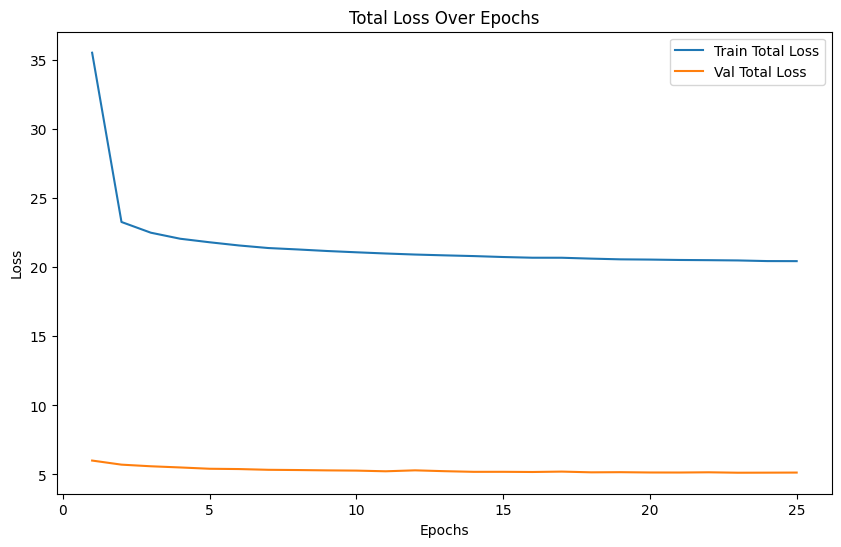

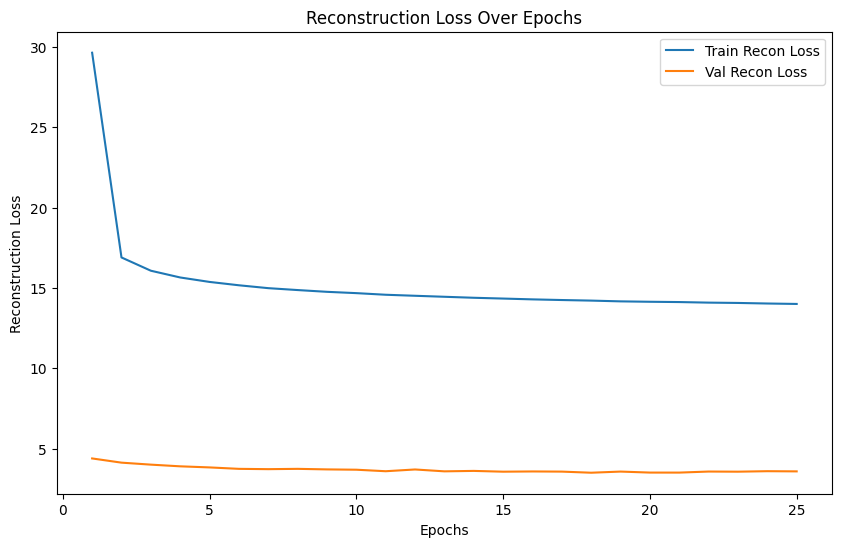

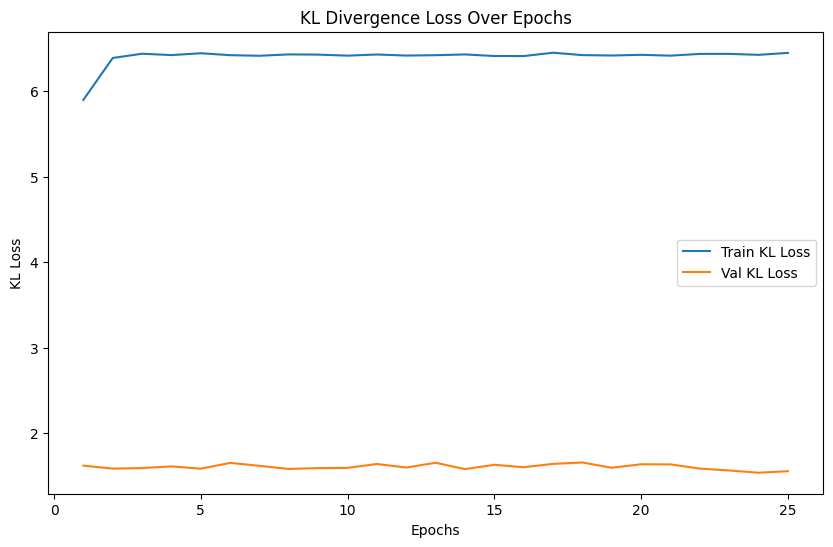

In [25]:
# Define hyperparameters
latent_dim = 20
num_epochs = 25
batch_size = 64
learning_rate = 1e-3
beta = 1  # Weight for KL Divergence

# Define the VAE model, optimizer
vae = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

metrics = train_vae(vae, train_loader, val_loader, optimizer, num_epochs=25, device=device)
plot_metrics(metrics)

Evaluating on Test Dataset: 100%|██████████| 313/313 [00:02<00:00, 140.49it/s]


Test Total Loss: 25.6449
Test Reconstruction Loss: 17.8700
Test KL Divergence Loss: 7.7749


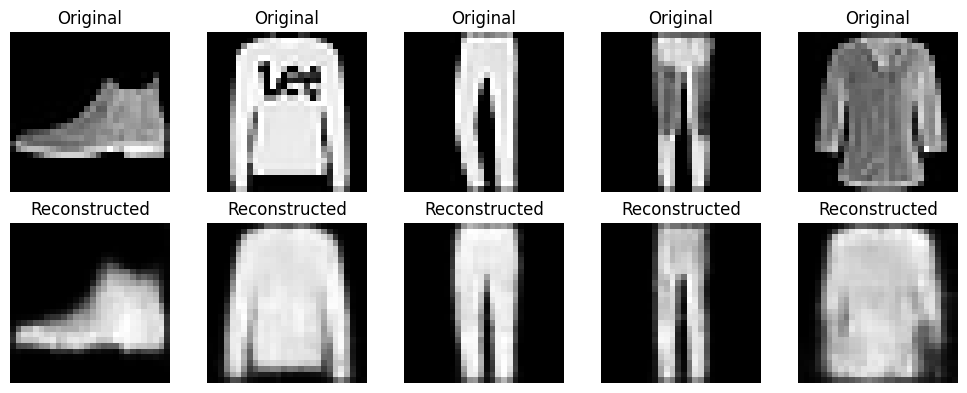

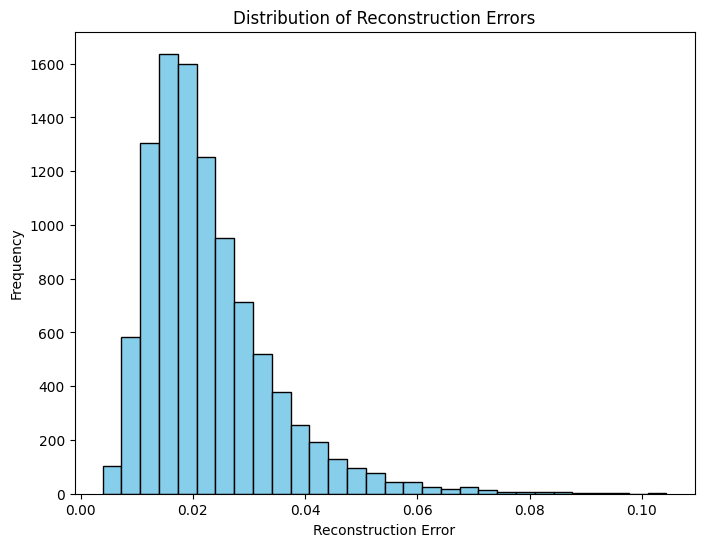

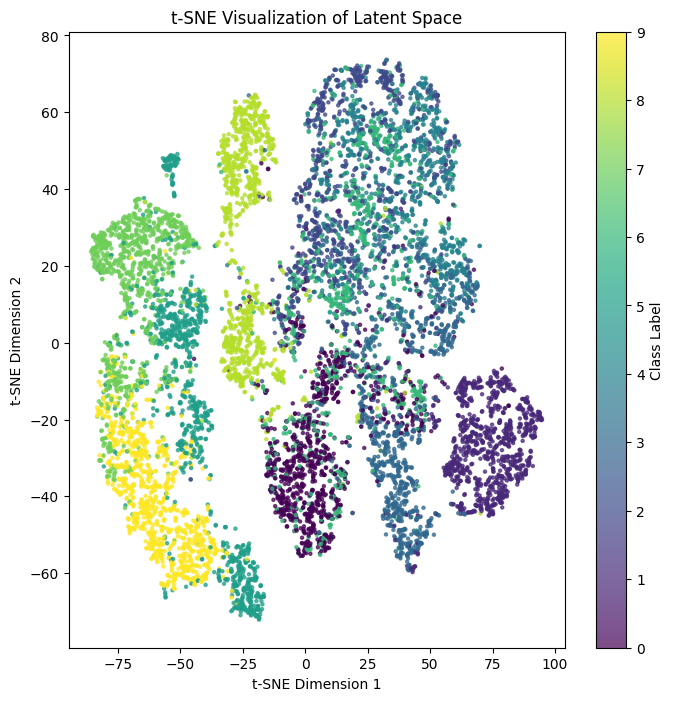

Total Loss: 25.644897021484375
Reconstruction Loss: 17.869994595336912
KL Divergence Loss: 7.774902452087402


In [29]:
# Run evaluation

metrics = evaluate_vae(vae, test_loader, device)

# Print the returned metrics
print(f"Total Loss: {metrics['test_total_loss']}")
print(f"Reconstruction Loss: {metrics['test_recon_loss']}")
print(f"KL Divergence Loss: {metrics['test_kl_loss']}")

## DAE

In [30]:
def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * torch.randn_like(data)
    return torch.clamp(noisy_data, 0.0, 1.0)


In [31]:
def train_dae(model, train_loader, val_loader, optimizer, num_epochs=25, device="cpu", noise_factor=0.5):
    model.to(device)
    metrics = {
        "train_loss": [],
        "val_loss": [],
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = batch[0].to(device)
            noisy_images = add_noise(images, noise_factor).to(device)

            optimizer.zero_grad()

            # Forward pass
            recon_images = model(noisy_images)
            loss = nn.MSELoss()(recon_images, images)  # Reconstruction loss

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Log training metrics
        train_loss = running_loss / len(train_loader)
        metrics["train_loss"].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = batch[0].to(device)
                noisy_images = add_noise(images, noise_factor).to(device)

                # Forward pass
                recon_images = model(noisy_images)
                loss = nn.MSELoss()(recon_images, images)
                val_loss += loss.item()

        # Log validation metrics
        val_loss /= len(val_loader)
        metrics["val_loss"].append(val_loss)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return metrics

In [39]:
def evaluate_dae(model, test_loader, device, noise_factor=0.5):

    model.eval()
    test_loss = 0.0
    all_noisy_images = []
    all_recon_images = []
    all_original_images = []
    sample_metrics = {"recon_errors": []}
    latent_space = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating on Test Dataset"):
            images, targets = batch
            images = images.to(device)
            noisy_images = add_noise(images, noise_factor).to(device)

            # Forward pass
            recon_images = model(noisy_images)
            loss = nn.MSELoss()(recon_images, images)
            test_loss += loss.item()

            # Save reconstruction errors
            batch_recon_errors = ((images - recon_images) ** 2).mean(dim=(1, 2, 3)).cpu().numpy()
            sample_metrics["recon_errors"].extend(batch_recon_errors)

            # Save images for visualization
            all_original_images.append(images.cpu())
            all_noisy_images.append(noisy_images.cpu())
            all_recon_images.append(recon_images.cpu())

            # Collect latent representations (
            if hasattr(model, "encoder"):
                encoded = model.encoder(noisy_images).cpu()
                latent_space.append(encoded.view(encoded.size(0), -1).cpu())
                labels.append(targets)

    test_loss /= len(test_loader)



    latent_space = torch.cat(latent_space, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()


    print(f"Test Loss: {test_loss:.4f}")

    visualize_dae_results(all_original_images, all_noisy_images, all_recon_images)

    plot_reconstruction_errors(sample_metrics["recon_errors"])

    visualize_latent_space(latent_space, labels)

    return {
        "test_loss": test_loss,
        "sample_recon_errors": np.mean(sample_metrics["recon_errors"]),
    }

def visualize_dae_results(original_images, noisy_images, recon_images, num_samples=10):
    original_images = torch.cat(original_images, dim=0)[:num_samples]
    noisy_images = torch.cat(noisy_images, dim=0)[:num_samples]
    recon_images = torch.cat(recon_images, dim=0)[:num_samples]

    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))
    for i in range(num_samples):
        axes[0, i].imshow(original_images[i, 0], cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        axes[1, i].imshow(noisy_images[i, 0], cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title("Noisy")

        axes[2, i].imshow(recon_images[i, 0], cmap="gray")
        axes[2, i].axis("off")
        axes[2, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()


def plot_reconstruction_errors(recon_errors):
    plt.figure(figsize=(8, 6))
    plt.hist(recon_errors, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title("Distribution of Reconstruction Errors")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.show()


def visualize_latent_space(latent_space, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_space)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap="viridis", s=5, alpha=0.7)
    plt.colorbar(scatter, label="Class Label")
    plt.title("t-SNE Visualization of Latent Space")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()


Epoch 1/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 141.03it/s]


Epoch 1/25:
Train Loss: 0.0309, Val Loss: 0.0209


Epoch 2/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 141.09it/s]


Epoch 2/25:
Train Loss: 0.0197, Val Loss: 0.0188


Epoch 3/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 146.76it/s]


Epoch 3/25:
Train Loss: 0.0182, Val Loss: 0.0177


Epoch 4/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 182.26it/s]


Epoch 4/25:
Train Loss: 0.0173, Val Loss: 0.0169


Epoch 5/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.65it/s]


Epoch 5/25:
Train Loss: 0.0166, Val Loss: 0.0165


Epoch 6/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 203.23it/s]


Epoch 6/25:
Train Loss: 0.0162, Val Loss: 0.0159


Epoch 7/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 180.94it/s]


Epoch 7/25:
Train Loss: 0.0158, Val Loss: 0.0160


Epoch 8/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.03it/s]


Epoch 8/25:
Train Loss: 0.0155, Val Loss: 0.0158


Epoch 9/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.79it/s]


Epoch 9/25:
Train Loss: 0.0153, Val Loss: 0.0154


Epoch 10/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.04it/s]


Epoch 10/25:
Train Loss: 0.0151, Val Loss: 0.0149


Epoch 11/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 199.89it/s]


Epoch 11/25:
Train Loss: 0.0150, Val Loss: 0.0149


Epoch 12/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.42it/s]


Epoch 12/25:
Train Loss: 0.0148, Val Loss: 0.0149


Epoch 13/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.36it/s]


Epoch 13/25:
Train Loss: 0.0147, Val Loss: 0.0147


Epoch 14/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.68it/s]


Epoch 14/25:
Train Loss: 0.0146, Val Loss: 0.0148


Epoch 15/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 200.69it/s]


Epoch 15/25:
Train Loss: 0.0145, Val Loss: 0.0145


Epoch 16/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 199.30it/s]


Epoch 16/25:
Train Loss: 0.0144, Val Loss: 0.0146


Epoch 17/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.81it/s]


Epoch 17/25:
Train Loss: 0.0143, Val Loss: 0.0145


Epoch 18/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 202.79it/s]


Epoch 18/25:
Train Loss: 0.0143, Val Loss: 0.0146


Epoch 19/25 - Validation: 100%|██████████| 375/375 [00:01<00:00, 199.77it/s]


Epoch 19/25:
Train Loss: 0.0142, Val Loss: 0.0143


Epoch 20/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 165.50it/s]


Epoch 20/25:
Train Loss: 0.0142, Val Loss: 0.0143


Epoch 21/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 166.34it/s]


Epoch 21/25:
Train Loss: 0.0141, Val Loss: 0.0146


Epoch 22/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 154.71it/s]


Epoch 22/25:
Train Loss: 0.0141, Val Loss: 0.0141


Epoch 23/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 141.80it/s]


Epoch 23/25:
Train Loss: 0.0140, Val Loss: 0.0143


Epoch 24/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 141.66it/s]


Epoch 24/25:
Train Loss: 0.0140, Val Loss: 0.0141


Epoch 25/25 - Validation: 100%|██████████| 375/375 [00:02<00:00, 148.76it/s]


Epoch 25/25:
Train Loss: 0.0140, Val Loss: 0.0141


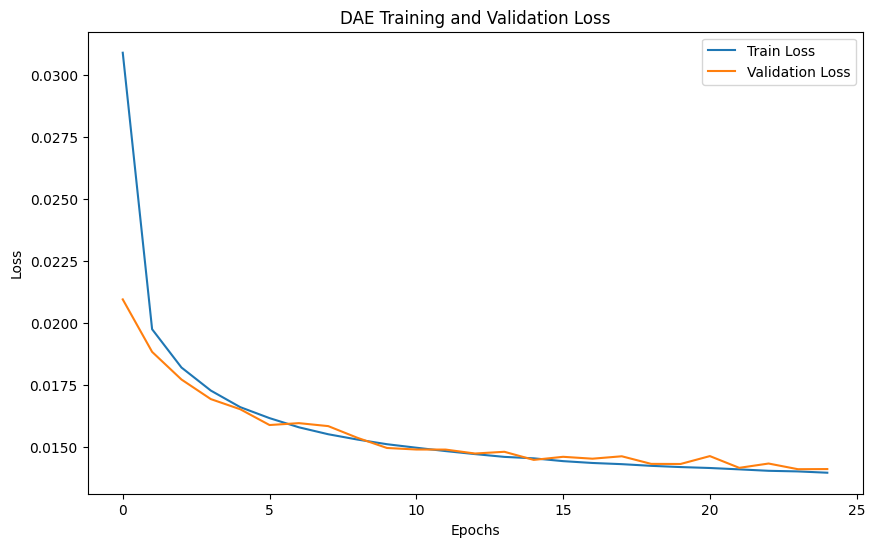

Evaluating on Test Dataset: 100%|██████████| 313/313 [00:01<00:00, 196.70it/s]


Test Loss: 0.0142


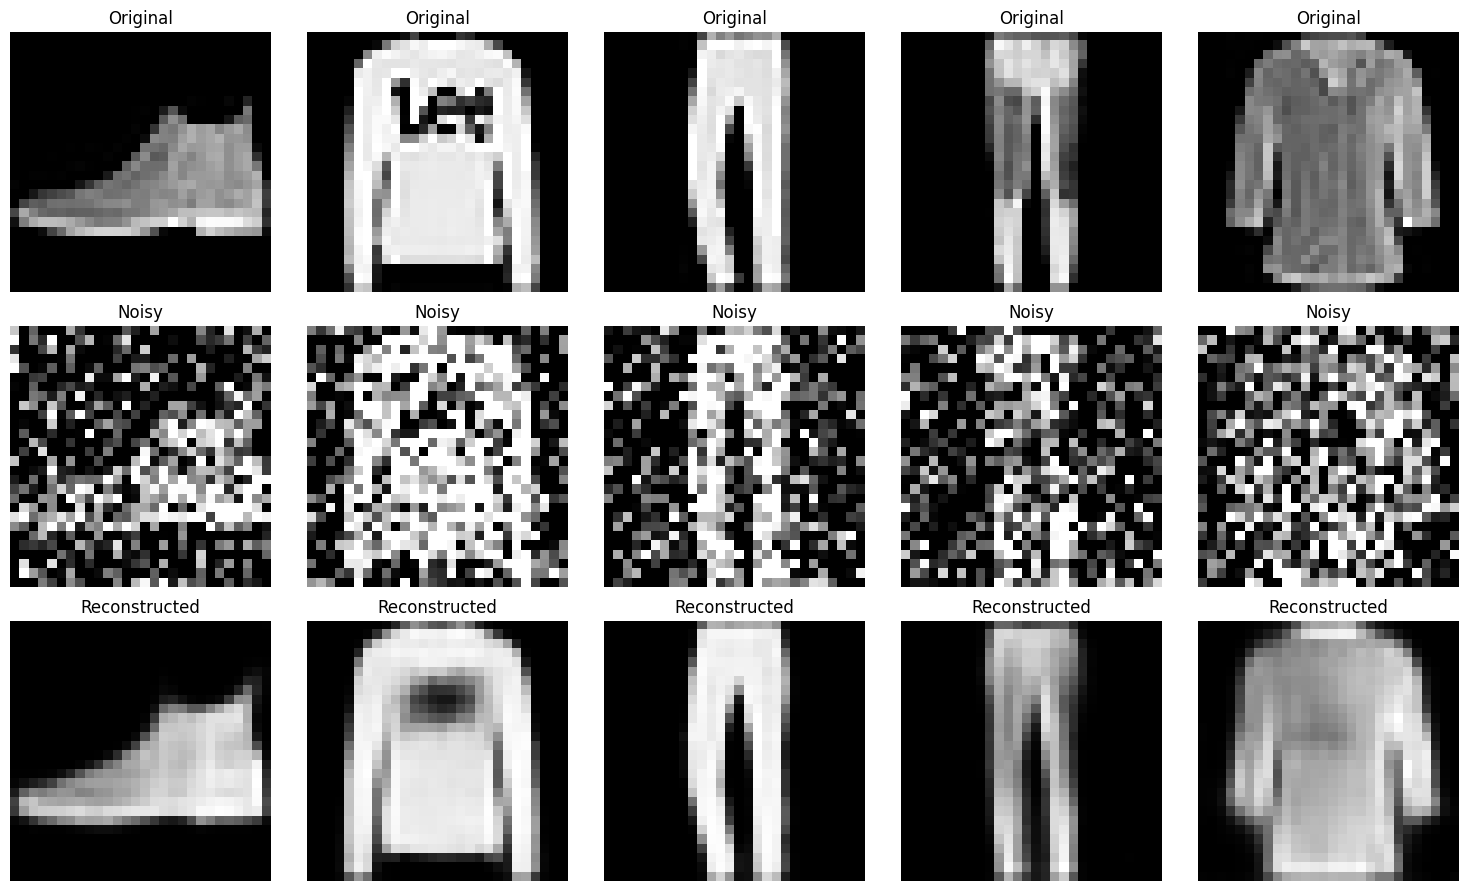

0.014162093049849564

In [33]:
# Initialize the DAE model (reuse the Autoencoder class structure)
dae = Autoencoder().to(device)

# Define optimizer
optimizer = torch.optim.Adam(dae.parameters(), lr=1e-3)

# Train the DAE
metrics = train_dae(dae, train_loader, val_loader, optimizer, num_epochs=25, device=device, noise_factor=0.5)

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DAE Training and Validation Loss")
plt.legend()
plt.show()

# Evaluate the DAE on test data
evaluate_dae(dae, test_loader, device, noise_factor=0.5)


Evaluating on Test Dataset: 100%|██████████| 313/313 [00:01<00:00, 173.33it/s]


Test Loss: 0.0141


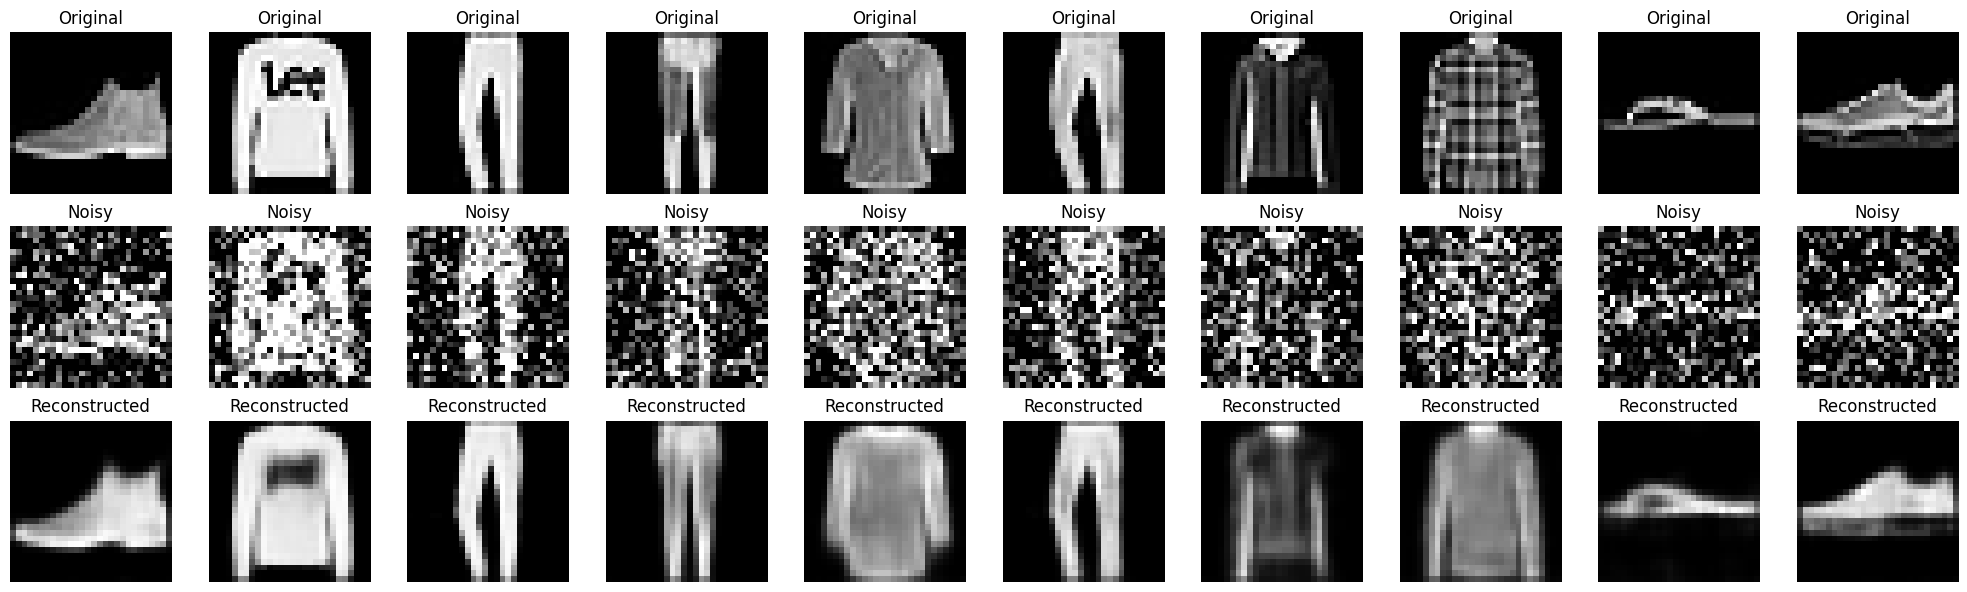

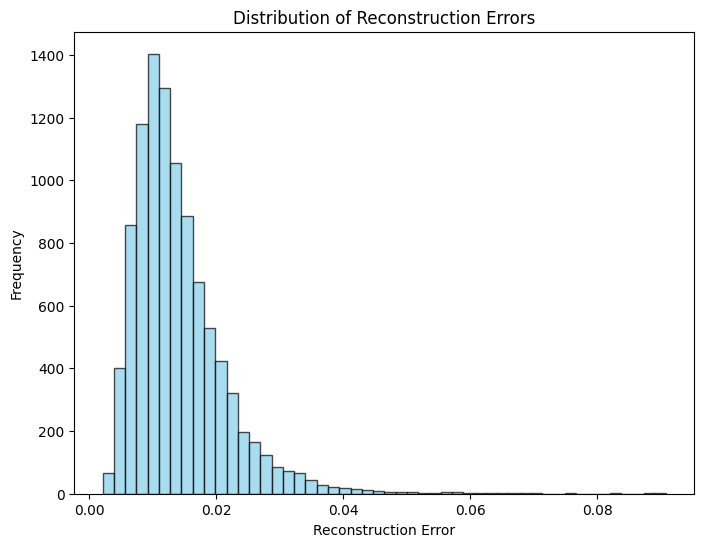

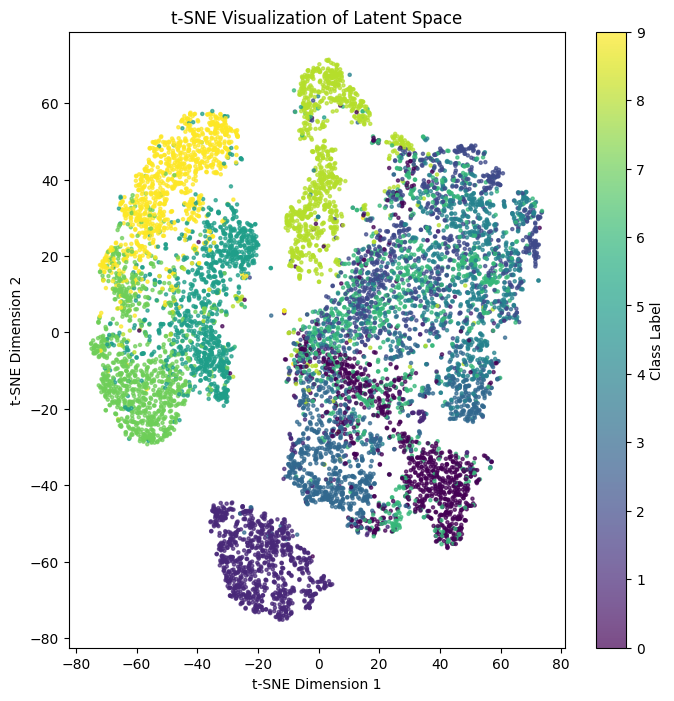

{'test_loss': 0.014129267303279033, 'sample_recon_errors': 0.014120155}

In [40]:
evaluate_dae(dae, test_loader, device, noise_factor=0.5)

### Transfer Learning

In [47]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10, device="cuda"):
        super(Classifier, self).__init__()
        self.encoder = encoder.to(device)


        dummy_input = torch.randn(1, 1, 28, 28).to(device)
        with torch.no_grad():
            encoder_output = self.encoder(dummy_input)
            self.flattened_size = encoder_output.view(-1).shape[0]


        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.to(next(self.encoder.parameters()).device)
        with torch.no_grad():  # Freeze the encoder
            x = self.encoder(x)
        x = self.fc(x)  # Pass through the classification layers
        return x


In [42]:
def train_classifier(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device="cpu"):
    model.to(device)
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        metrics["train_loss"].append(train_loss)
        metrics["train_accuracy"].append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100. * correct / total
        metrics["val_loss"].append(val_loss)
        metrics["val_accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return metrics


In [48]:
ae_encoder = ae.encoder
vae_encoder = vae.encoder
dae_encoder = dae.encoder

ae_classifier = Classifier(encoder=ae_encoder, num_classes=10)
vae_classifier = Classifier(encoder=vae_encoder, num_classes=10)
dae_classifier = Classifier(encoder=dae_encoder, num_classes=10)

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

ae_optimizer = torch.optim.Adam(ae_classifier.fc.parameters(), lr=learning_rate)
vae_optimizer = torch.optim.Adam(vae_classifier.fc.parameters(), lr=learning_rate)
dae_optimizer = torch.optim.Adam(dae_classifier.fc.parameters(), lr=learning_rate)

# Train the classifiers
print("Training AE Classifier...")
ae_metrics = train_classifier(ae_classifier, train_loader, val_loader, ae_optimizer, criterion, num_epochs=10, device=device)

print("Training VAE Classifier...")
vae_metrics = train_classifier(vae_classifier, train_loader, val_loader, vae_optimizer, criterion, num_epochs=10, device=device)

print("Training DAE Classifier...")
dae_metrics = train_classifier(dae_classifier, train_loader, val_loader, dae_optimizer, criterion, num_epochs=10, device=device)

Training AE Classifier...


Epoch 1/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 210.49it/s]


Epoch 1/10:
Train Loss: 0.4809, Train Accuracy: 82.39%
Val Loss: 0.3872, Val Accuracy: 85.28%


Epoch 2/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 210.42it/s]


Epoch 2/10:
Train Loss: 0.3782, Train Accuracy: 85.99%
Val Loss: 0.3511, Val Accuracy: 87.12%


Epoch 3/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 190.15it/s]


Epoch 3/10:
Train Loss: 0.3472, Train Accuracy: 87.12%
Val Loss: 0.3249, Val Accuracy: 88.04%


Epoch 4/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 165.82it/s]


Epoch 4/10:
Train Loss: 0.3298, Train Accuracy: 87.63%
Val Loss: 0.3409, Val Accuracy: 87.23%


Epoch 5/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 214.80it/s]


Epoch 5/10:
Train Loss: 0.3189, Train Accuracy: 88.07%
Val Loss: 0.3189, Val Accuracy: 88.53%


Epoch 6/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 160.52it/s]


Epoch 6/10:
Train Loss: 0.3055, Train Accuracy: 88.55%
Val Loss: 0.3151, Val Accuracy: 88.23%


Epoch 7/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 153.76it/s]


Epoch 7/10:
Train Loss: 0.2957, Train Accuracy: 88.94%
Val Loss: 0.3222, Val Accuracy: 88.22%


Epoch 8/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 196.51it/s]


Epoch 8/10:
Train Loss: 0.2888, Train Accuracy: 89.14%
Val Loss: 0.3284, Val Accuracy: 88.15%


Epoch 9/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 214.02it/s]


Epoch 9/10:
Train Loss: 0.2790, Train Accuracy: 89.56%
Val Loss: 0.3060, Val Accuracy: 88.47%


Epoch 10/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 214.63it/s]


Epoch 10/10:
Train Loss: 0.2744, Train Accuracy: 89.59%
Val Loss: 0.3022, Val Accuracy: 88.92%
Training VAE Classifier...


Epoch 1/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 221.78it/s]


Epoch 1/10:
Train Loss: 0.5849, Train Accuracy: 79.49%
Val Loss: 0.4364, Val Accuracy: 84.58%


Epoch 2/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 221.21it/s]


Epoch 2/10:
Train Loss: 0.4154, Train Accuracy: 84.89%
Val Loss: 0.3943, Val Accuracy: 85.50%


Epoch 3/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 217.20it/s]


Epoch 3/10:
Train Loss: 0.3786, Train Accuracy: 86.09%
Val Loss: 0.3666, Val Accuracy: 86.53%


Epoch 4/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 164.92it/s]


Epoch 4/10:
Train Loss: 0.3581, Train Accuracy: 86.90%
Val Loss: 0.3617, Val Accuracy: 86.62%


Epoch 5/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 161.22it/s]


Epoch 5/10:
Train Loss: 0.3440, Train Accuracy: 87.40%
Val Loss: 0.3682, Val Accuracy: 86.35%


Epoch 6/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 219.46it/s]


Epoch 6/10:
Train Loss: 0.3322, Train Accuracy: 87.81%
Val Loss: 0.3535, Val Accuracy: 87.13%


Epoch 7/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 220.84it/s]


Epoch 7/10:
Train Loss: 0.3216, Train Accuracy: 88.06%
Val Loss: 0.3398, Val Accuracy: 87.61%


Epoch 8/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 220.22it/s]


Epoch 8/10:
Train Loss: 0.3126, Train Accuracy: 88.46%
Val Loss: 0.3291, Val Accuracy: 88.11%


Epoch 9/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 221.28it/s]


Epoch 9/10:
Train Loss: 0.3055, Train Accuracy: 88.78%
Val Loss: 0.3276, Val Accuracy: 88.27%


Epoch 10/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 201.15it/s]


Epoch 10/10:
Train Loss: 0.2972, Train Accuracy: 88.86%
Val Loss: 0.3249, Val Accuracy: 88.12%
Training DAE Classifier...


Epoch 1/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 149.28it/s]


Epoch 1/10:
Train Loss: 0.5028, Train Accuracy: 81.87%
Val Loss: 0.4172, Val Accuracy: 84.31%


Epoch 2/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 189.37it/s]


Epoch 2/10:
Train Loss: 0.4002, Train Accuracy: 85.32%
Val Loss: 0.3765, Val Accuracy: 85.88%


Epoch 3/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 207.08it/s]


Epoch 3/10:
Train Loss: 0.3688, Train Accuracy: 86.28%
Val Loss: 0.3830, Val Accuracy: 85.80%


Epoch 4/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 213.64it/s]


Epoch 4/10:
Train Loss: 0.3463, Train Accuracy: 87.02%
Val Loss: 0.3552, Val Accuracy: 87.28%


Epoch 5/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 212.09it/s]


Epoch 5/10:
Train Loss: 0.3265, Train Accuracy: 87.70%
Val Loss: 0.3656, Val Accuracy: 86.51%


Epoch 6/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 210.10it/s]


Epoch 6/10:
Train Loss: 0.3141, Train Accuracy: 88.09%
Val Loss: 0.3589, Val Accuracy: 86.87%


Epoch 7/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 212.72it/s]


Epoch 7/10:
Train Loss: 0.2972, Train Accuracy: 88.76%
Val Loss: 0.3479, Val Accuracy: 87.36%


Epoch 8/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 155.74it/s]


Epoch 8/10:
Train Loss: 0.2870, Train Accuracy: 89.06%
Val Loss: 0.3612, Val Accuracy: 87.27%


Epoch 9/10 - Validation: 100%|██████████| 375/375 [00:02<00:00, 160.27it/s]


Epoch 9/10:
Train Loss: 0.2769, Train Accuracy: 89.57%
Val Loss: 0.3542, Val Accuracy: 87.37%


Epoch 10/10 - Validation: 100%|██████████| 375/375 [00:01<00:00, 211.17it/s]

Epoch 10/10:
Train Loss: 0.2651, Train Accuracy: 90.02%
Val Loss: 0.3489, Val Accuracy: 87.93%


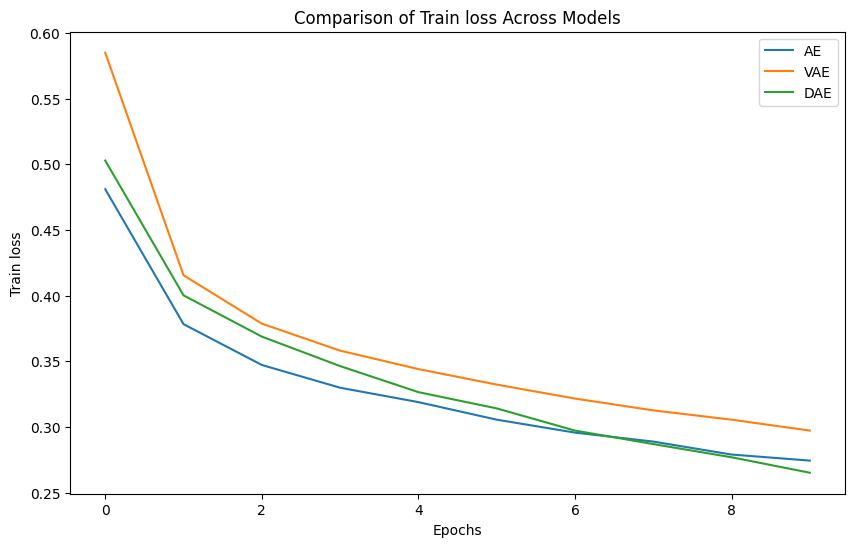

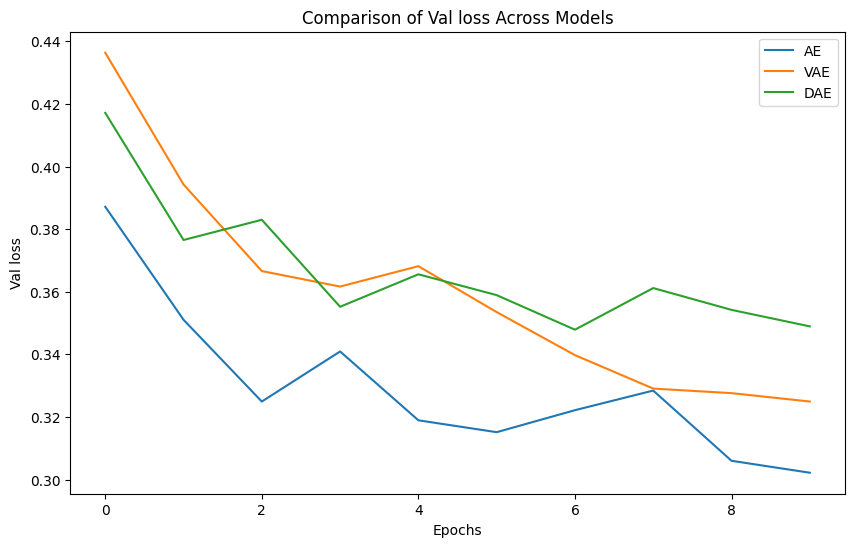

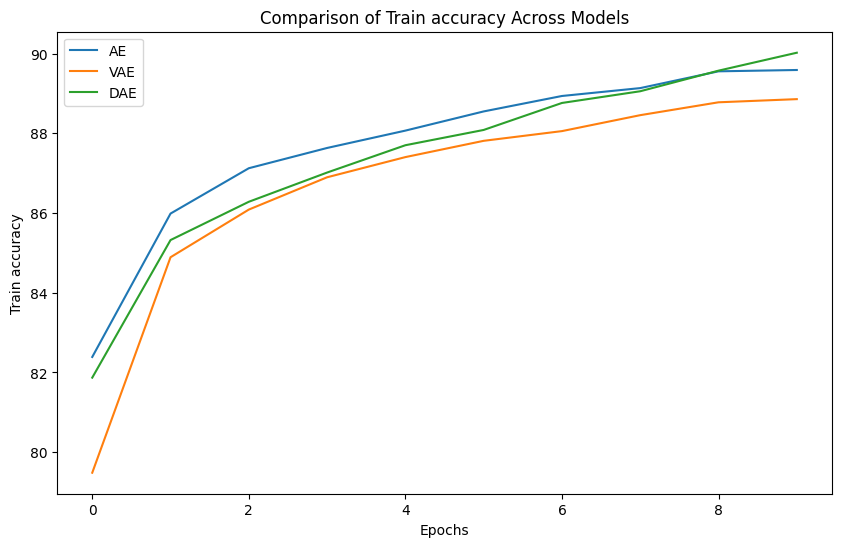

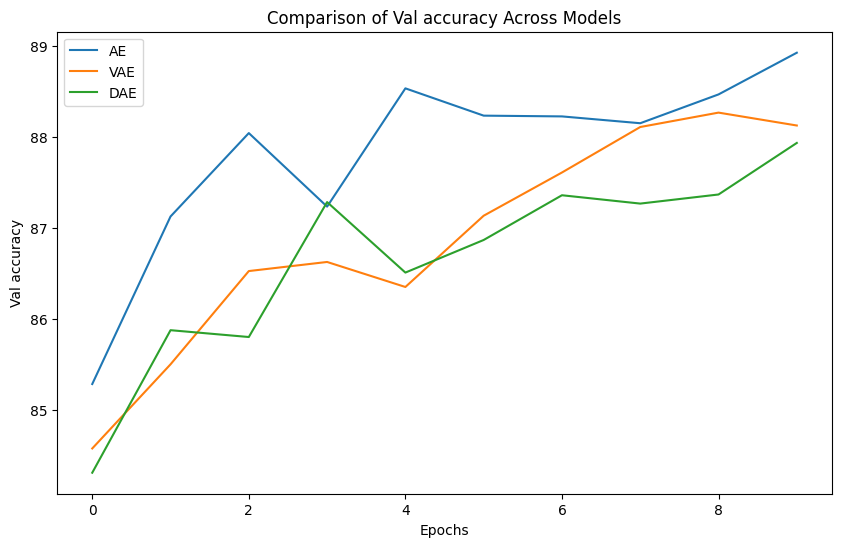

In [49]:
def plot_comparison(metrics_list, labels, metric_name):

    plt.figure(figsize=(10, 6))
    for metrics, label in zip(metrics_list, labels):
        plt.plot(metrics[metric_name], label=label)

    plt.xlabel("Epochs")
    plt.ylabel(metric_name.replace("_", " ").capitalize())
    plt.title(f"Comparison of {metric_name.replace('_', ' ').capitalize()} Across Models")
    plt.legend()
    plt.show()

# Compare training and validation metrics
plot_comparison([ae_metrics, vae_metrics, dae_metrics], labels=["AE", "VAE", "DAE"], metric_name="train_loss")
plot_comparison([ae_metrics, vae_metrics, dae_metrics], labels=["AE", "VAE", "DAE"], metric_name="val_loss")
plot_comparison([ae_metrics, vae_metrics, dae_metrics], labels=["AE", "VAE", "DAE"], metric_name="train_accuracy")
plot_comparison([ae_metrics, vae_metrics, dae_metrics], labels=["AE", "VAE", "DAE"], metric_name="val_accuracy")


In [65]:

def evaluate_models(models, loaders, model_labels, device, num_classes=10):

    train_loader, val_loader, test_loader = loaders
    results = []

    for model, label in zip(models, model_labels):
        print(f"Evaluating {label}...")

        # Store metrics
        true_labels = []
        predicted_labels = []
        latent_vectors = []

        # Evaluation loop
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = outputs.max(1)

                # Store labels and predictions
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

                # Extract latent vectors (encoder output)
                latent = model.encoder(images)
                latent = latent.view(latent.size(0), -1).cpu().numpy()  # Flatten to 2D
                latent_vectors.append(latent)

        # Combine latent vectors
        latent_vectors = np.concatenate(latent_vectors, axis=0)

        # Calculate metrics
        accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels)) * 100
        report = classification_report(
            true_labels,
            predicted_labels,
            target_names=[f"Class {i}" for i in range(num_classes)],
            output_dict=True,
        )
        precision = report["weighted avg"]["precision"]
        recall = report["weighted avg"]["recall"]
        f1_score = report["weighted avg"]["f1-score"]

        # Visualize Confusion Matrix
        print(f"Confusion Matrix for {label}:")
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(num_classes)], yticklabels=[f"Class {i}" for i in range(num_classes)])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.show()

        # Append results
        results.append({
            "Model": label,
            "Accuracy": accuracy,
            "Precision": precision * 100,
            "Recall": recall * 100,
            "F1 Score": f1_score * 100
        })

    # Create a results DataFrame
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:")
    print(results_df)

    return results_df;


Evaluating AE...
Confusion Matrix for AE:


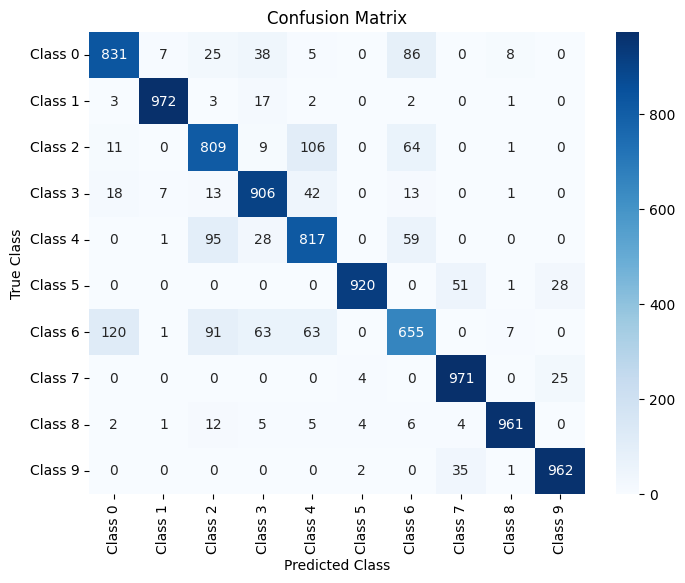

Latent Space Representation for AE:


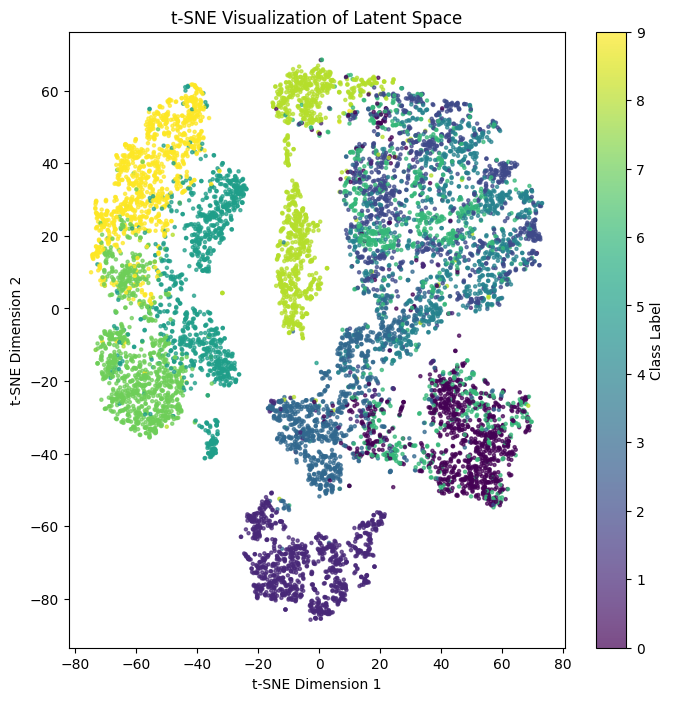

Evaluating VAE...
Confusion Matrix for VAE:


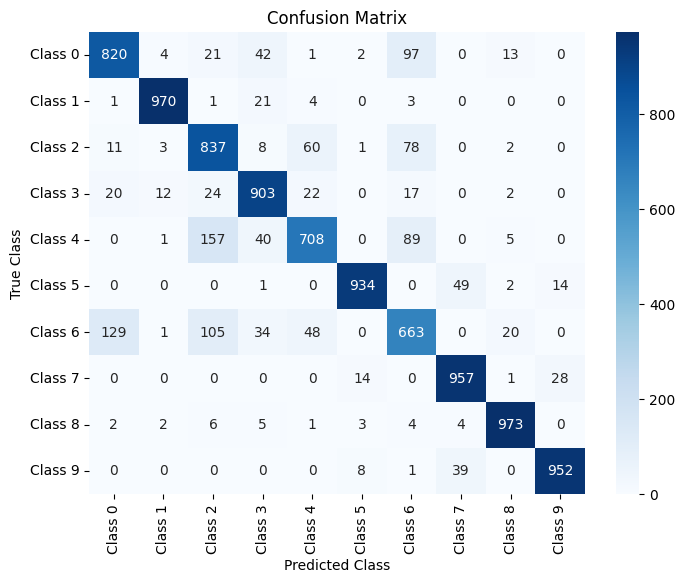

Latent Space Representation for VAE:


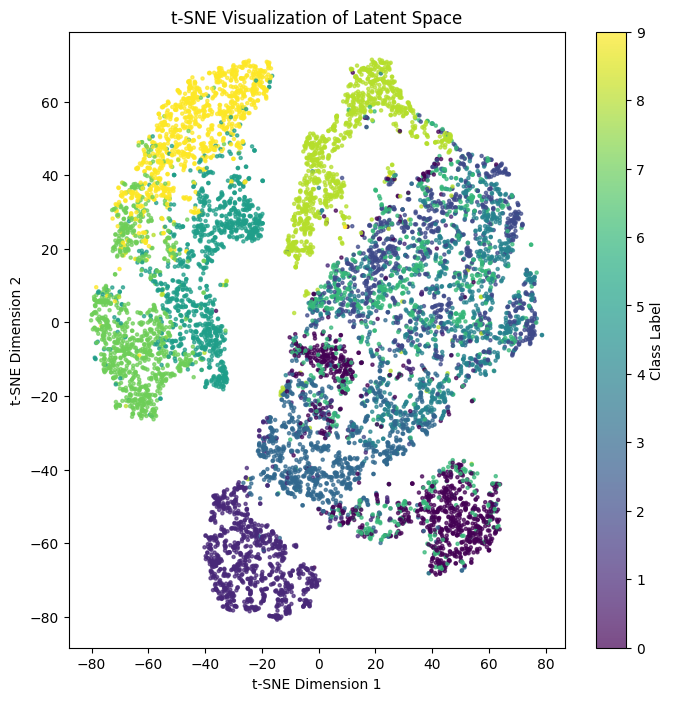

Evaluating DAE...
Confusion Matrix for DAE:


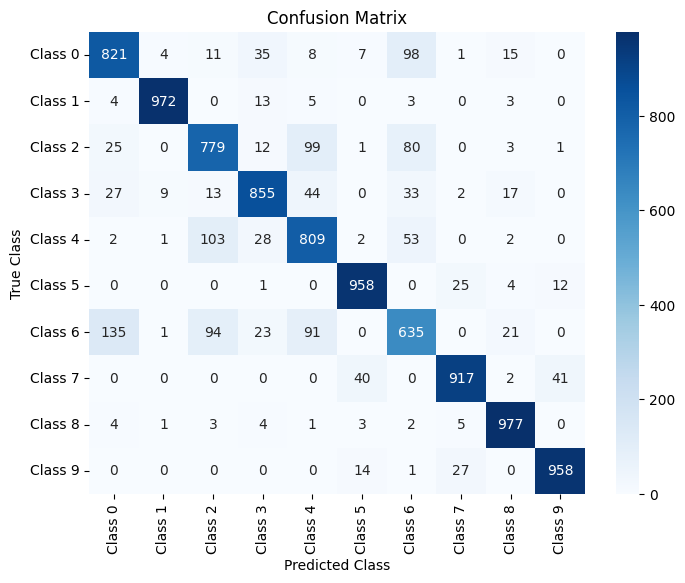

Latent Space Representation for DAE:


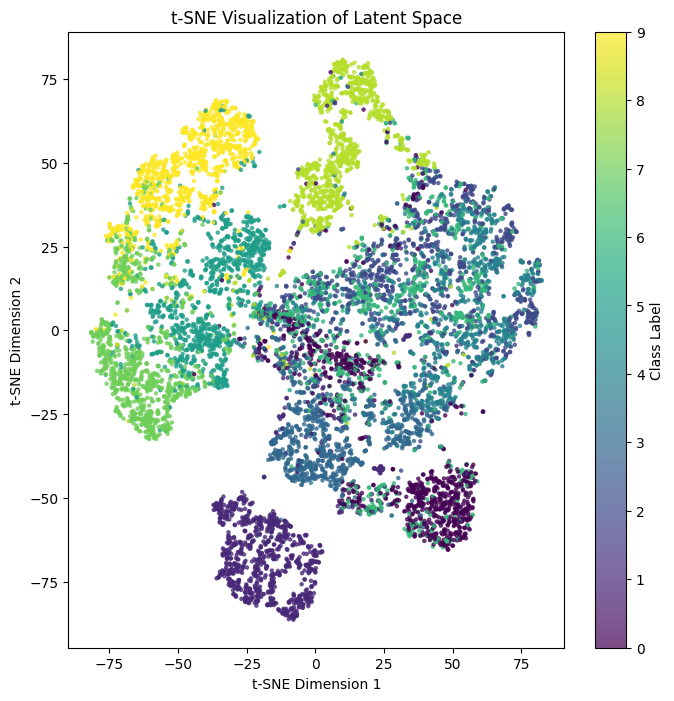

In [57]:
models = [ae_classifier, vae_classifier, dae_classifier]
model_labels = ["AE", "VAE", "DAE"]
results = evaluate_models(models, (train_loader, val_loader, test_loader), model_labels, device="cuda", num_classes=10)

Evaluating AE...
Confusion Matrix for AE:


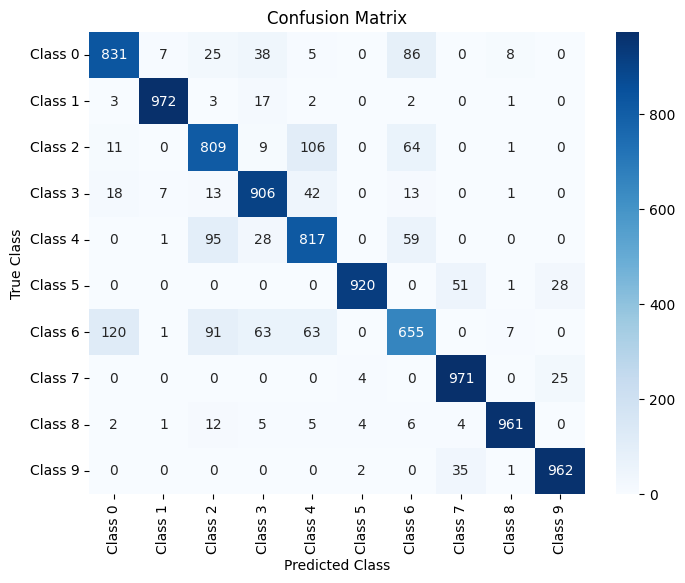

Evaluating VAE...
Confusion Matrix for VAE:


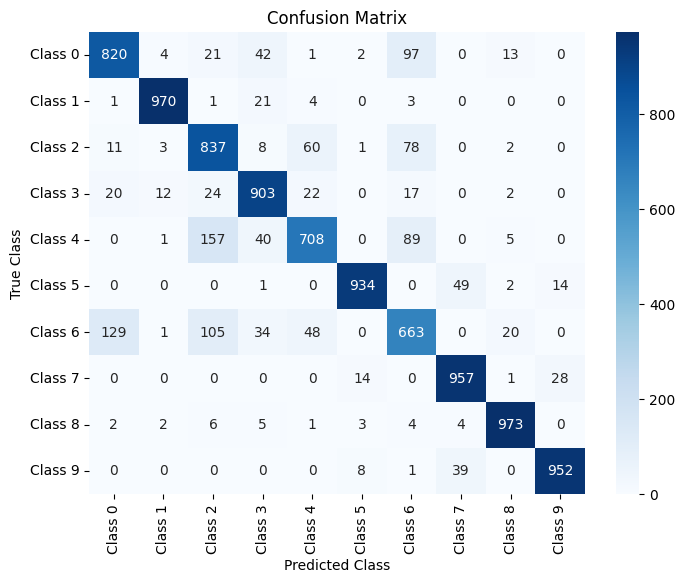

Evaluating DAE...
Confusion Matrix for DAE:


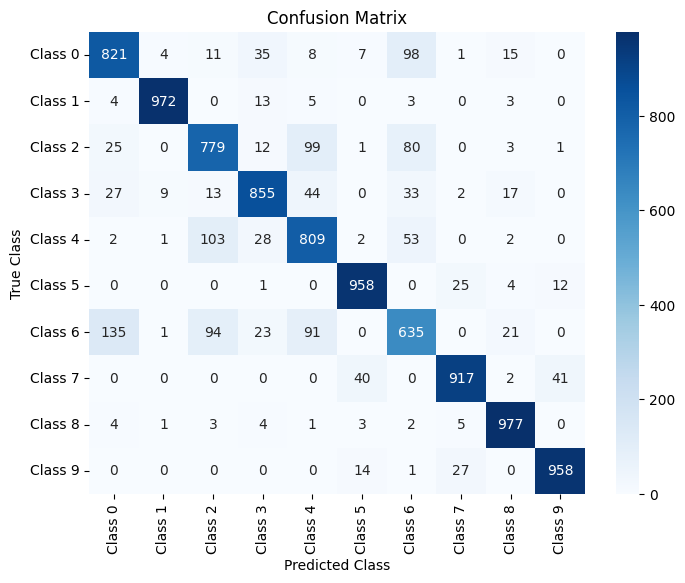


Summary of Results:
  Model  Accuracy  Precision  Recall   F1 Score
0    AE     88.04  88.058260   88.04  87.983766
1   VAE     87.17  87.269736   87.17  87.105281
2   DAE     86.81  86.702114   86.81  86.723023


In [66]:
results = evaluate_models(models, (train_loader, val_loader, test_loader), model_labels, device="cuda", num_classes=10)

In [72]:
from torchviz import make_dot
from torchsummary import summary

In [73]:
# For Classification Model
dummy_input = torch.randn(1, 1, 28, 28).to(device)
classification_output = ae_classifier(dummy_input)
make_dot(classification_output, params=dict(list(ae_classifier.named_parameters()))).render("AE_Classifier", format="png")

autoencoder_output = ae(dummy_input)
make_dot(autoencoder_output, params=dict(list(ae.named_parameters()))).render("AE", format="png")

summary(ae_classifier, input_size=(1, 28, 28))
summary(ae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3            [-1, 8, 14, 14]             584
              ReLU-4            [-1, 8, 14, 14]               0
            Conv2d-5             [-1, 16, 5, 5]           1,168
              ReLU-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 32, 5, 5]           4,640
              ReLU-8             [-1, 32, 5, 5]               0
            Conv2d-9            [-1, 128, 3, 3]          36,992
             ReLU-10            [-1, 128, 3, 3]               0
          Flatten-11                 [-1, 1152]               0
           Linear-12                  [-1, 128]         147,584
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [74]:
# For Classification Model
dummy_input = torch.randn(1, 1, 28, 28).to(device)
classification_output = vae_classifier(dummy_input)
make_dot(classification_output, params=dict(list(vae_classifier.named_parameters()))).render("VAE_Classifier", format="png")

# For Autoencoder Model
autoencoder_output = ae(dummy_input)
make_dot(autoencoder_output, params=dict(list(vae.named_parameters()))).render("VAE", format="png")

summary(vae_classifier, input_size=(1, 28, 28))
summary(vae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           1,168
              ReLU-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 32, 4, 4]           4,640
              ReLU-6             [-1, 32, 4, 4]               0
           Flatten-7                  [-1, 512]               0
           Flatten-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 72,842
Trainable params: 72,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [75]:
# For Classification Model
dummy_input = torch.randn(1, 1, 28, 28).to(device)
classification_output = dae_classifier(dummy_input)
make_dot(classification_output, params=dict(list(dae_classifier.named_parameters()))).render("DAE_Classifier", format="png")

# For Autoencoder Model
autoencoder_output = dae(dummy_input)
make_dot(autoencoder_output, params=dict(list(dae.named_parameters()))).render("DAE", format="png")

summary(dae_classifier, input_size=(1, 28, 28))
summary(dae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3            [-1, 8, 14, 14]             584
              ReLU-4            [-1, 8, 14, 14]               0
            Conv2d-5             [-1, 16, 5, 5]           1,168
              ReLU-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 32, 5, 5]           4,640
              ReLU-8             [-1, 32, 5, 5]               0
            Conv2d-9            [-1, 128, 3, 3]          36,992
             ReLU-10            [-1, 128, 3, 3]               0
          Flatten-11                 [-1, 1152]               0
           Linear-12                  [-1, 128]         147,584
             ReLU-13                  [-1, 128]               0
           Linear-14                   

## YOLO

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/YOLO/yolov5/


/content/drive/MyDrive/YOLO/yolov5


In [ ]:
ls -l

total 398105
-rw-------  1 root root 407654437 Nov 23 21:47 APA-Work2.rar
drwx------ 12 root root      4096 Nov 23 22:40 yolov5/


In [ ]:
!unrar x "APA-Work2.rar" "APA-Work2"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from APA-Work2.rar

Creating    APA-Work2                                                 OK
Creating    APA-Work2/YOLO                                            OK
Creating    APA-Work2/YOLO/KITTI_dataset                              OK
Creating    APA-Work2/YOLO/KITTI_dataset/Imgs                         OK
Extracting  APA-Work2/YOLO/KITTI_dataset/Imgs/000000.png                   0%  OK 
Extracting  APA-Work2/YOLO/KITTI_dataset/Imgs/000001.png                   0%  OK 
Extracting  APA-Work2/YOLO/KITTI_dataset/Imgs/000002.png                   0%  OK 
Extracting  APA-Work2/YOLO/KITTI_dataset/Imgs/000003.png                   0%  OK 
Extracting  APA-Work2/YOLO/KITTI_dataset/Imgs/000004.png                   0%  OK 
Extracting  APA-Work2/YOLO/KITTI_dataset/Imgs/000005.png                   1%  OK 
Extracting  APA-Work2/YOLO/KITTI_dataset/Imgs/000

In [ ]:
yaml_content = """
train: /content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/train/
val: /content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/val/
nc: 3
names: ['car','person','cyclist']
"""

with open('/content/drive/MyDrive/YOLO/yolov5/data/APA2024_2.yaml', 'w') as f:
    f.write(yaml_content)


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths to your dataset
images_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/Imgs'
labels_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/labels'

# Output paths for training and validation splits
train_images_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/train/images'
valid_images_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/val/images'
train_labels_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/train/labels'
valid_labels_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/val/labels'

# Create directories if they don't exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(valid_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(valid_labels_path, exist_ok=True)

# Get list of all image files
image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.txt')])

# Ensure each image has a corresponding label
image_files = [f for f in image_files if os.path.exists(os.path.join(labels_path, f.replace('.png', '.txt').replace('.jpg', '.txt').replace('.jpeg', '.txt')))]

# Split into train and validation sets (80/20 split)
train_images, valid_images = train_test_split(image_files, test_size=0.2, random_state=42)

# Move files to their respective directories
for img in train_images:
    shutil.move(os.path.join(images_path, img), os.path.join(train_images_path, img))
    shutil.move(os.path.join(labels_path, img.replace('.png', '.txt').replace('.jpg', '.txt').replace('.jpeg', '.txt')),
                os.path.join(train_labels_path, img.replace('.png', '.txt').replace('.jpg', '.txt').replace('.jpeg', '.txt')))

for img in valid_images:
    shutil.move(os.path.join(images_path, img), os.path.join(valid_images_path, img))
    shutil.move(os.path.join(labels_path, img.replace('.png', '.txt').replace('.jpg', '.txt').replace('.jpeg', '.txt')),
                os.path.join(valid_labels_path, img.replace('.png', '.txt').replace('.jpg', '.txt').replace('.jpeg', '.txt')))

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(valid_images)} images")


Training set: 400 images
Validation set: 100 images


In [ ]:
import os

# Paths to label directories
train_labels_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/train/labels'
val_labels_path = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/val/labels'

def clean_labels(labels_path):
    for label_file in os.listdir(labels_path):
        file_path = os.path.join(labels_path, label_file)
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Fix the labels
        cleaned_lines = []
        for line in lines:
            parts = line.strip().split()
            parts[0] = str(int(float(parts[0])))  # Convert class_id to an integer
            cleaned_lines.append(' '.join(parts) + '\n')

        # Rewrite the file with cleaned labels
        with open(file_path, 'w') as f:
            f.writelines(cleaned_lines)

# Clean train and validation labels
clean_labels(train_labels_path)
clean_labels(val_labels_path)

print("Labels cleaned: class IDs converted to integers.")


Labels cleaned: class IDs converted to integers.


In [ ]:
ls -l

total 401
-rw------- 1 root root 14120 Nov 23 21:52 benchmarks.py
-rw------- 1 root root   393 Nov 23 21:52 CITATION.cff
drwx------ 2 root root  4096 Nov 23 21:52 classify/
-rw------- 1 root root  5006 Nov 23 21:52 CONTRIBUTING.md
drwx------ 5 root root  4096 Nov 23 22:37 data/
-rw------- 1 root root 23691 Nov 23 21:52 detect.py
-rw------- 1 root root 68550 Nov 23 21:52 export.py
-rw------- 1 root root 23968 Nov 23 21:52 hubconf.py
-rw------- 1 root root 34523 Nov 23 21:52 LICENSE
drwx------ 5 root root  4096 Nov 23 21:57 models/
drwx------ 2 root root  4096 Nov 23 21:57 __pycache__/
-rw------- 1 root root  5377 Nov 23 21:52 pyproject.toml
-rw------- 1 root root 43266 Nov 23 21:52 README.md
-rw------- 1 root root 43375 Nov 23 21:52 README.zh-CN.md
-rw------- 1 root root  1598 Nov 23 21:52 requirements.txt
drwx------ 2 root root  4096 Nov 23 21:52 segment/
-rw------- 1 root root 47131 Nov 23 21:52 train.py
-rw------- 1 root root 41447 Nov 23 21:52 tutorial.ipynb
drwx------ 9 root root  

In [ ]:
!python train.py --img 416 --batch 16 --epochs 50 --data data/APA2024_2.yaml --weights yolov5s.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-23 23:34:38.714993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 23:34:38.734718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 23:34:38.742557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leoleocordeiro (leoleocordeiro-university-of-coimbra). Use `wa

Run just for CAR from scratch

In [ ]:
import os
import shutil

# Paths to the original datasest
original_images_train = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/train/images'
original_images_val = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/val/images'
original_labels_train = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/train/labels'
original_labels_val = '/content/drive/MyDrive/YOLO/APA-Work2/YOLO/KITTI_dataset/val/labels'

# Paths to the filtered dataset
filtered_dataset_path = '/content/drive/MyDrive/APA-Work2/YOLO/KITTI_dataset_filtered'
filtered_images_train = os.path.join(filtered_dataset_path, 'train/images')
filtered_images_val = os.path.join(filtered_dataset_path, 'val/images')
filtered_labels_train = os.path.join(filtered_dataset_path, 'train/labels')
filtered_labels_val = os.path.join(filtered_dataset_path, 'val/labels')

# Create directories for the filtered dataset
os.makedirs(filtered_images_train, exist_ok=True)
os.makedirs(filtered_images_val, exist_ok=True)
os.makedirs(filtered_labels_train, exist_ok=True)
os.makedirs(filtered_labels_val, exist_ok=True)

def filter_and_copy_data(images_path, labels_path, filtered_images_path, filtered_labels_path, target_class=0):
    for label_file in os.listdir(labels_path):
        label_file_path = os.path.join(labels_path, label_file)

        # Read the label file
        with open(label_file_path, 'r') as f:
            lines = f.readlines()

        # Keep only annotations for the target class
        filtered_lines = [line for line in lines if line.strip().split()[0] == str(target_class)]

        # If the file contains annotations for the target class, copy it and the corresponding image
        if filtered_lines:
            # Copy the label file
            filtered_label_file_path = os.path.join(filtered_labels_path, label_file)
            with open(filtered_label_file_path, 'w') as f:
                f.writelines(filtered_lines)

            # Copy the corresponding image
            image_file = label_file.replace('.txt', '.png')  # Replace with appropriate extension
            image_file_path = os.path.join(images_path, image_file)
            if not os.path.exists(image_file_path):  # Check for .jpg or other formats
                image_file = label_file.replace('.txt', '.jpg')
                image_file_path = os.path.join(images_path, image_file)
            filtered_image_file_path = os.path.join(filtered_images_path, image_file)
            shutil.copy(image_file_path, filtered_image_file_path)

# Apply filtering and copying for train and validation sets
filter_and_copy_data(original_images_train, original_labels_train, filtered_images_train, filtered_labels_train, target_class=0)
filter_and_copy_data(original_images_val, original_labels_val, filtered_images_val, filtered_labels_val, target_class=0)

print("Filtered dataset created at:", filtered_dataset_path)


Filtered dataset created at: /content/drive/MyDrive/APA-Work2/YOLO/KITTI_dataset_filtered


In [ ]:
yaml_content = """
train: /content/drive/MyDrive/APA-Work2/YOLO/KITTI_dataset_filtered/train/
val: /content/drive/MyDrive/APA-Work2/YOLO/KITTI_dataset_filtered/val/
nc: 1
names: ['car']
"""

with open('/content/drive/MyDrive/YOLO/yolov5/data/APA2024_car.yaml', 'w') as f:
    f.write(yaml_content)

In [ ]:
!python train.py --imgsz 416 --batch-size 16 --epochs 50 --data data/APA2024_car.yaml --weights '' --cfg yolov5s.yaml --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-23 23:55:53.379098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 23:55:53.398697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 23:55:53.404978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leoleocordeiro (leoleocordeiro-university-of-coimbra). Use `wa